# Probabilistic Programming with Pyro
> A tutorial of how to use Pyro for probabilistic models.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/ppl-pyro-intro.png

##  Intro to Pyro

[Pyro](http://pyro.ai/) is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. It enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.

### Models and Probability distributions
**Models** are the basic unit of probabilistic programs in pyro, they represent simplified or abstract descriptions of a process by which data are generated. Models in pyro are expressed as *stochastic functions* which implies that models can be composed, reused, imported, and serialized just like regular Python callables. **Probability distributions** (pimitive stochastic functions) are important class of models (stochastic functions) used explicitly to compute the probability of the outputs given the inputs.  Pyro uses [PyTorch’s distribution library](https://pytorch.org/docs/master/distributions.html) which contains parameterizable probability distributions and sampling functions. This allows the construction of stochastic computation graphs and stochastic gradient estimators for optimization. Each probability distributions are equipped with several  methods such as:

* **prob()**: $\log p(\mathbf{x} \mid \theta ^{*})$
* **mean**: $\mathbb{E}_{p(\mathbf{x} \mid \theta ^{*})}[\mathbf{x}]$
* **sample**: $\mathbf{x}^{*} \sim  {p(\mathbf{x} \mid \theta ^{*})}$


You can also create custom distributions using [transforms](https://pytorch.org/docs/master/distributions.html#module-torch.distributions.transforms).


**Example 1**: Let define the unit normal distribution $\mathcal{N}(0,1)$, draw  sample $x$ and  compute the log probability according to the distribution.

In [1]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pyro.set_rng_seed(101)
torch.manual_seed(101)
torch.set_printoptions(precision=3)
%matplotlib inline

In [2]:
mu = 0  
sigma = 1 
normal=dist.Normal(mu, sigma) 
x = normal.rsample() # draw a sample from N(1,1)
print("sample", x.item())
#To compute the log probability according to the distribution
print("prob", torch.exp(normal.log_prob(x)).item()) # score the sample from N(1,1)

sample -1.3905061483383179
prob 0.15172401070594788


### Sample and Param statements
Pyro simplifies the process of sampling from distributions with the use of  **pyro.sample** statement. The **pyro.sample** statement  call stochastic functions or models with a *unique name* as identifier. Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. Using **pyro.sample** statement, Pyro can implement  various manipulations that underlie inference algorithms.

```python
x = pyro.sample("name", fn, obs)

"""
name – name of sample
fn – distribution class or function
obs – observed datum (optional; should only be used in context of inference) optionally specified in kwargs
"""
```
**Example 2**: Let sample from previous normal distribution created in example 1.

In [3]:
mu = 0  
sigma = 1 
x = pyro.sample("my_sample", dist.Normal(mu, sigma))
print(x)

tensor(-0.815)


The above code generate a random value and records it in the Pyro runtime.

In [4]:
data=2
x = pyro.sample("my_sample", dist.Normal(mu, sigma), obs=data)
print(x)

2


/opt/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at my_sample
  RuntimeWarning)


The above code conditions a stochatsic function on observed data. This should run on inference.

Pyro use  **pyro.param** statement to  saves the variable as a parameter in the param store. To interact with the param store. The **pyro.param** statement is used by pyro to  declares a learnable parameter.


```python
x = pyro.param("name", init_value, constraints)

"""
name – name of param
init_value – initial value
constraint – torch constraint
"""
```
**Example 3**: Let create theta parameter

In [5]:
theta = pyro.param("theta", torch.tensor(1.0), constraint=dist.constraints.positive)

## Simple PPL model

Consider the following Poison Regression model
\begin{align}
y(t) &\sim \lambda \exp(-\lambda)\\
\lambda &\sim \exp(c + m(t))\\
c &\sim \mathcal{N}(1, 1)\\
m &\sim \mathcal{N}(0, 1)
\end{align}



In [6]:
def model(y):
    slope = pyro.sample("slope", dist.Normal(0, 0.1))
    intercept = pyro.sample("intercept", dist.Normal(0, 1))
    for t in range(len(y)):
        rate = torch.exp(intercept + slope * t)
        y[t] = pyro.sample("count_{}".format(t), dist.Poisson(rate),
                                obs=y[t])
    return slope, intercept, y

Given a pyro model.
We can
1. **Generate data from model**
2. **Learn parameters of the model from data**
3. **Use the model to predict future observation**.

### Generate data from model 
Running a Pyro model will generate a sample from the prior.



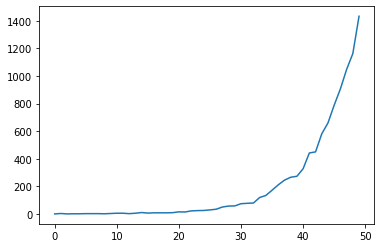

In [7]:
pyro.set_rng_seed(0)
# We pass counts = [None, ..., None] to indicate time duration.
true_slope, true_intercept, true_counts = model([None] * 50)
fig, ax =  plt.subplots(figsize=(6,4))
ax = sns.lineplot(x=np.arange(len(true_counts)),y=[c.item() for c in true_counts])

### Learn parameters of the model from data

To learn model parameters we pass the model to an inference algorithm and let the algorithm guess what the model is doing based on observed data. Inference algorithms in Pyro us arbitrary stochastic functions as approximate posterior distributions. that s. These functions are  called guide functions or **guides**  and contains **pyro.sample** and **pyro.param** statement. It is a stochastic function that represents a probability distribution over the latent (unobserved) variables. The guide can be arbitrary python code just like the model, but with a few requirements:

1. All unobserved sample statements that appear in the model appear in the guide. 
2. The guide has the same input signature as the model (i.e. takes the same arguments).
3. There are no pyro.sample statements with the obs keyword in the guide. These are exclusive to the model.
4. There are pyro.param statements, which are exclusive to the guide. These provide differentiation for the inputs to the pay_probs sample in the guide vs. the model.


For example if the model contains a random variable *z_1*

```python
def model():
    pyro.sample("z_1", ...)
```
then the guide needs to have a matching sample statement
```python
def guide():
    pyro.sample("z_1", ...)
```

Once a guide has been specified, we can then perform learning and inference which is an optimization problem of maximizing the evidence lower bound (ELBO). The ELBO, is a function of both $\theta$ and $\phi$, defined as an expectation w.r.t. to samples from the guide:

$${\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [
\log p_{\theta}({\bf x}, {\bf z}) - \log q_{\phi}({\bf z})
\right]$$

The **SVI** class is unified interface for stochastic variational inference in Pyro. To use this class you need to provide:
- the model, 
- the guide, and an 
- optimizer which is a wrapper a for a PyTorch optimizer as discusseced in below

```python
from pyro.infer import SVI, Trace_ELBO
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
```

The SVI object provides two methods, **step()** and **evaluate_loss()**, 
- The method step() takes a single gradient step and returns an estimate of the loss (i.e. minus the ELBO). 
- The method evaluate_loss() returns an estimate of the loss without taking a gradient step.

Both of these methods  accept an optional argument: **num_particles**, which denotes the number of samples used to compute the loss  and gradient.

The module **pyro.optim** provides support for optimization in Pyro. In particular it provides **PyroOptim**, which is used to wrap PyTorch optimizers and manage optimizers for dynamically generated parameters. **PyroOptim** takes two arguments: 
- a constructor for PyTorch optimizers *optim_constructor* and 
- a specification of the optimizer *arguments optim_args*

```python
from pyro.optim import Adam
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
```

Thus to learn model parameters we pass the model to an inference algorithm and let the algorithm guess what the model is doing based on observed data (here true_counts).

For the above example we will use Autoguide pyro inference algorithm:
- AutoLaplaceApproximation:Laplace approximation (quadratic approximation) approximates the posterior log𝑝(𝑧|𝑥) by a multivariate normal distribution in the unconstrained space.
- Autodelta: This implementation of AutoGuide uses Delta distributions to construct a MAP guide over the entire latent space. 

In [100]:
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

guide = AutoDelta(model)
svi = SVI(model, guide, Adam({"lr": 0.1}), Trace_ELBO())
for i in range(101):
    loss = svi.step(true_counts)  # true_counts is passed as argument to model()
    if i % 10 == 0:
        print("loss = {}".format(loss))

loss = 87295.88946688175
loss = 64525.8595520854
loss = 80838.8460238576
loss = 33014.93229973316
loss = 13704.865498423576
loss = 6232.828522503376
loss = 2017.9879159331322
loss = 631.3558134436607
loss = 170.10323333740234
loss = 198.57187271118164
loss = 207.4590385556221


In [102]:
print("true_slope = {}".format(true_slope))
print("true_intercept = {}".format(true_intercept))
guess = guide()
print("guess = {}".format(guess))

true_slope = 0.15409961342811584
true_intercept = -0.293428897857666
guess = {'slope': tensor(0.147, grad_fn=<ExpandBackward>), 'intercept': tensor(-0.054, grad_fn=<ExpandBackward>)}


###  Use model to predict future observation

A third way to use a Pyro model is to predict new observed data by guiding the model. This uses two of Pyro's effects:

- trace records guesses made by the guide, and
- replay conditions the model on those guesses, allowing the model to generate conditional samples.


**Traces** are directed graphs whose nodes represent primitive calls or input/output, and whose edges represent conditional dependence relationships between those primitive calls. It return a handler that records the inputs and outputs of primitive calls and their dependencies.

We can record its execution using trace and use the resulting data structure to compute the log-joint probability of all of the sample sites in the execution or extract all parameters.

In [111]:
trace = pyro.poutine.trace(model).get_trace([])
pprint({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in trace.nodes.items()
    if props['type'] == 'sample'
})

{'intercept': {'prob': tensor(0.250), 'value': tensor(-0.966)},
 'slope': {'prob': tensor(2.818), 'value': tensor(0.083)}}


In [112]:
print(trace.log_prob_sum().exp())

tensor(0.705)


Here, the trace feature will collect values every time they are sampled with sample and store them with the corresponding string name (that’s why we give each sample a name). With a little cleanup, we can print out the value and probability of each random variable’s value, along with the joint probability of the entire trace.

**Replay** return a callable that runs the original, reusing the values at sites in trace at those sites in the new trace.  makes sample statements behave as if they had sampled the values at the corresponding sites in the trace

In [115]:
from pyro import poutine

def forecast(forecast_steps=10):
    counts = true_counts + [None] * forecast_steps  # observed data + blanks to fill in
    guide_trace = poutine.trace(guide).get_trace(counts)
    _, _, counts = poutine.replay(model, guide_trace)(counts)
    return counts

We can now call forecast() multiple times to generate samples.

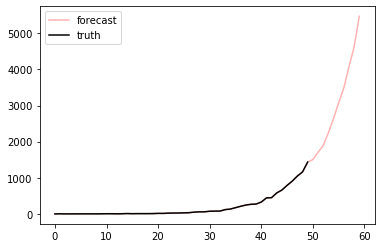

In [120]:
for _ in range(1):
    full_counts = forecast(10)
    forecast_counts = full_counts[len(true_counts):]
    plt.plot([c.item() for c in full_counts], "r",
                label=None if _ else "forecast", alpha=0.3)
plt.plot([c.item() for c in true_counts], "k-", label="truth")
plt.legend();

### References

1. [Pyro-ducomentation]()
2. [PPL models for timeseries forecasting](https://github.com/pyro-ppl/sandbox/)